In [217]:
import numpy as np
import torchio as tio

%load_ext autoreload
%autoreload 2

from mgmt.data.dataloader import CAIDMDataModule
from monai.visualize import blend_images

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# filepath_npz = "/Users/bryan/gdrive/Radiology-Research/brain_tumor/data/caidm_3d_96/data.npz"
# patient_exclusion_csv = "/Users/bryan/src/mgmt-promoter-methylation/mgmt/data/patient_exclusion.csv"

filepath_npz = "/home/bryan/data/brain_tumor/caidm_3d_96/data.npz"
patient_exclusion_csv = "/home/bryan/src/mgmt-promoter-methylation/mgmt/data/patient_exclusion.csv"

In [4]:
data_module = CAIDMDataModule(
    filepath_npz = filepath_npz,
    patient_exclusion_csv = patient_exclusion_csv,
    train_val_ratio = 0.85,
    batch_size = 16,
)

In [5]:
data_module.prepare_data()

In [5]:
# data_module.setup();

In [ ]:
        preprocess = tio.Compose(
            [
                tio.RescaleIntensity((-1, 1)),
                tio.CropOrPad(get_max_shape(self.subjects)),
                tio.EnsureShapeMultiple(8),  # for the U-Net
                tio.OneHot(),

In [6]:
subject = data_module.subjects[0]

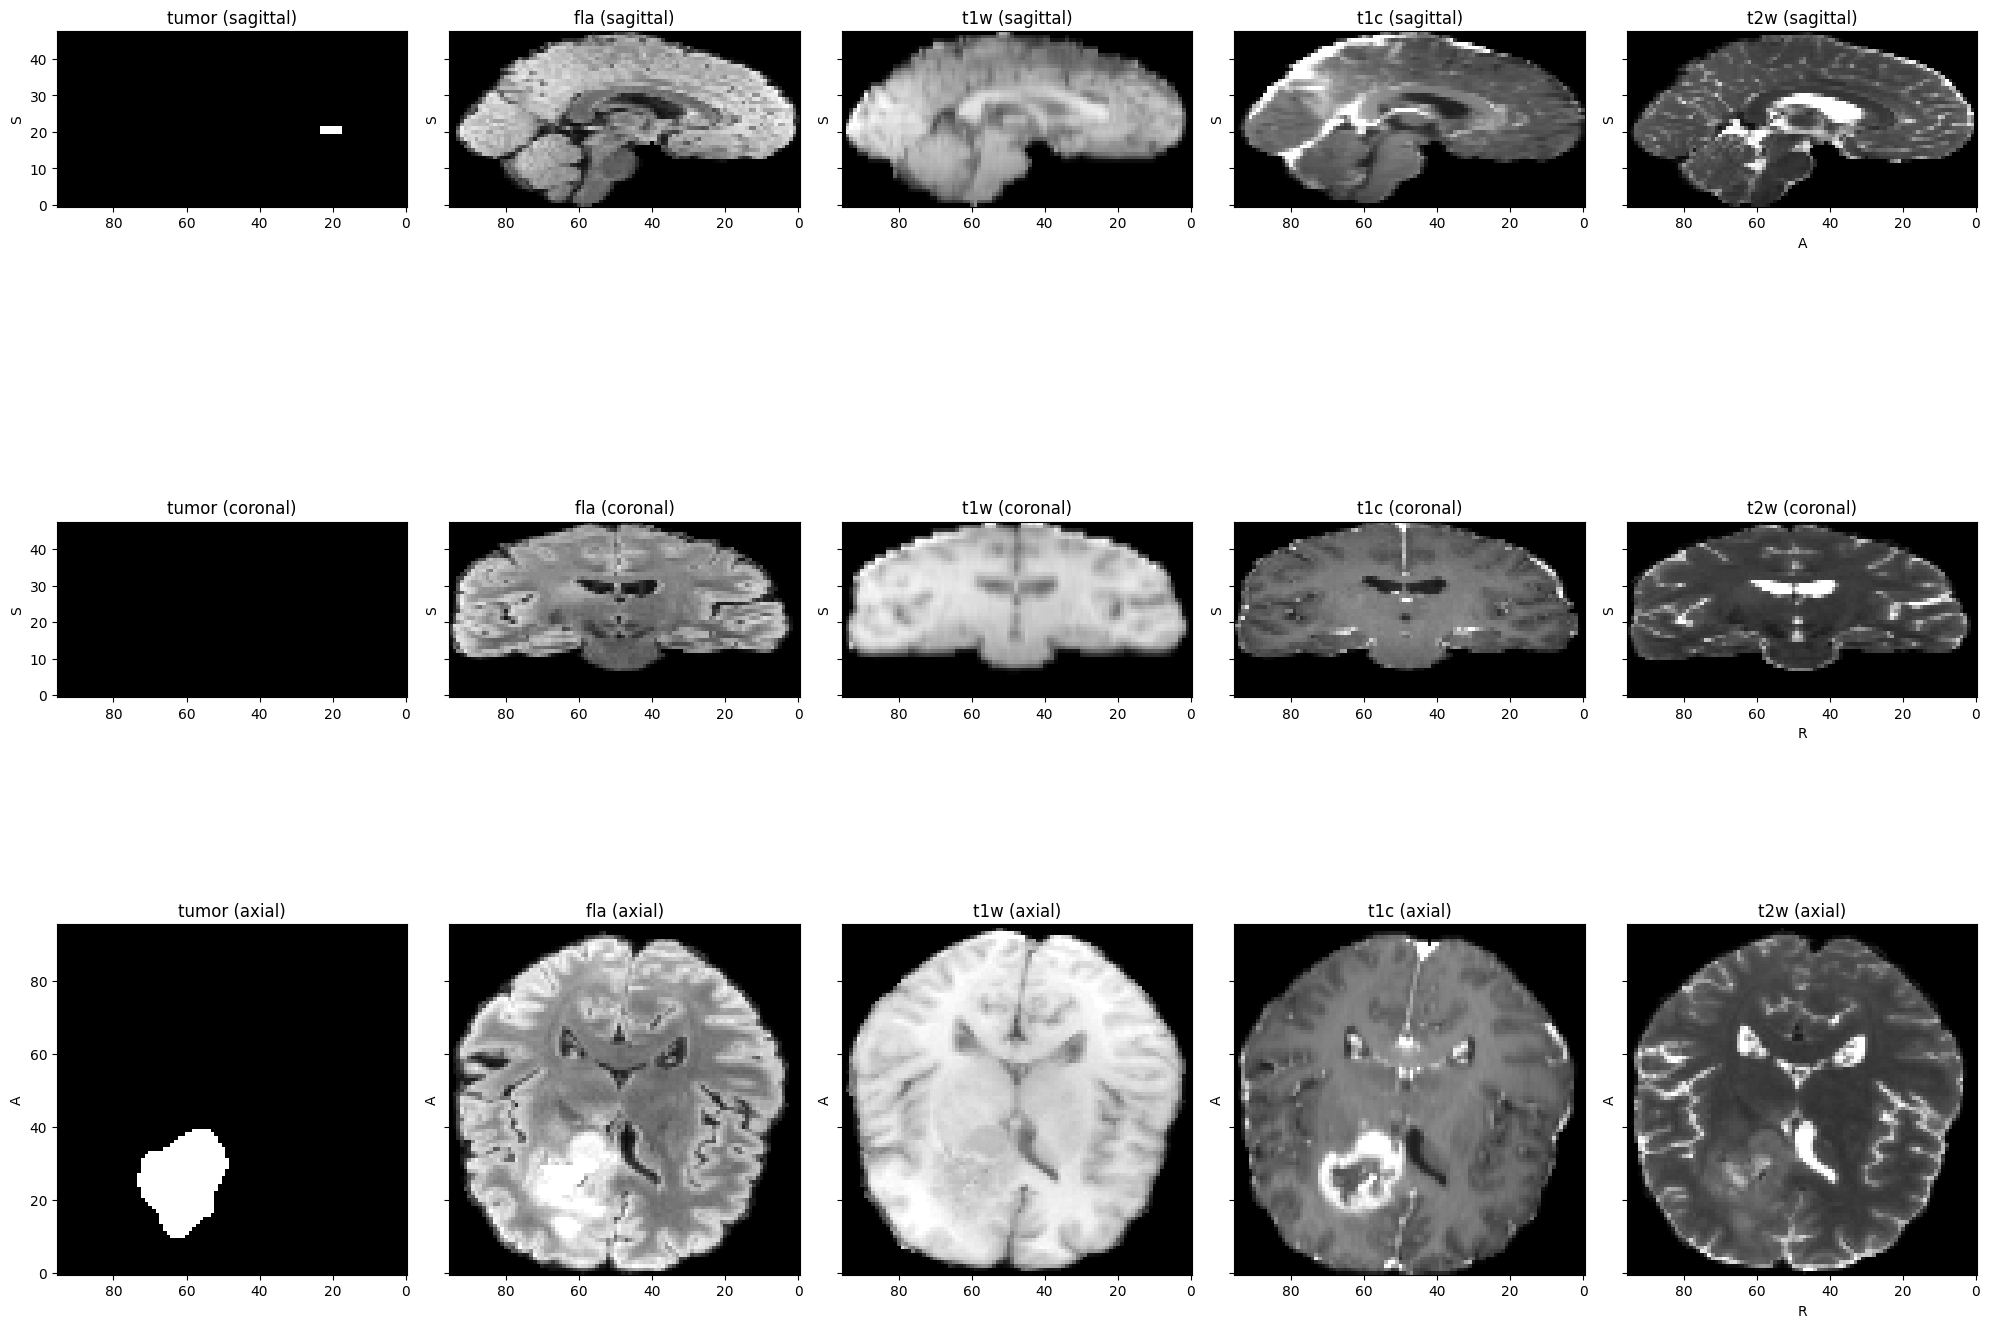

In [29]:
subject.plot(figsize=(20,20))

In [16]:
subject.get_images_names()

['tumor', 'fla', 't1w', 't1c', 't2w']

In [20]:
subject.get_images_dict(intensity_only=False)

{'tumor': LabelMap(shape: (1, 96, 96, 48); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.ByteTensor; memory: 432.0 KiB),
 'fla': ScalarImage(shape: (1, 96, 96, 48); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 1.7 MiB),
 't1w': ScalarImage(shape: (1, 96, 96, 48); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 1.7 MiB),
 't1c': ScalarImage(shape: (1, 96, 96, 48); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 1.7 MiB),
 't2w': ScalarImage(shape: (1, 96, 96, 48); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 1.7 MiB)}

In [22]:
subject["fla"]

ScalarImage(shape: (1, 96, 96, 48); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 1.7 MiB)

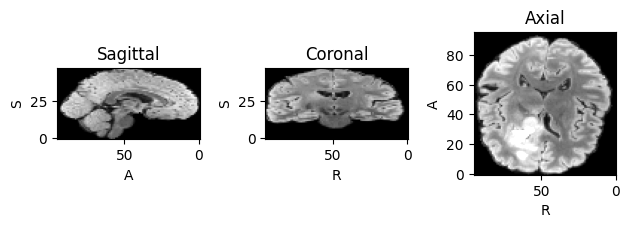

In [27]:
tio.visualization.plot_volume(
    subject["fla"],
);

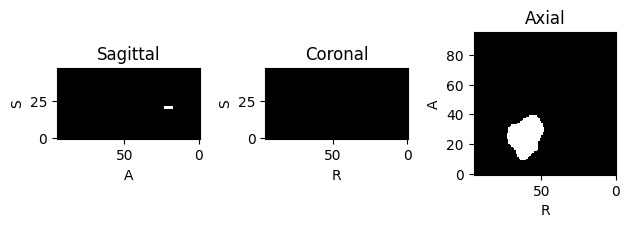

In [28]:
tio.visualization.plot_volume(
    subject["tumor"],
);

In [31]:
transform = tio.RescaleIntensity((-1, 1))

In [33]:
sub1 = transform(subject)

In [34]:
sub1

Subject(Keys: ('tumor', 'category_id', 'category', 'patient_id', 'fla', 't1w', 't1c', 't2w'); images: 5)

In [35]:
sub1.fla

ScalarImage(shape: (1, 96, 96, 48); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 1.7 MiB)

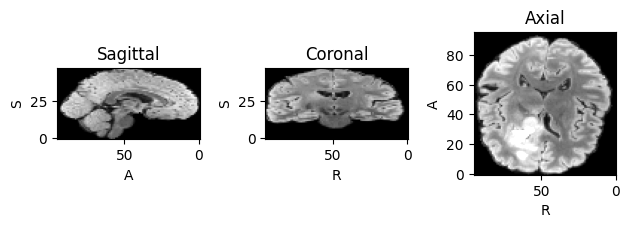

In [37]:
tio.visualization.plot_volume(subject["fla"]);

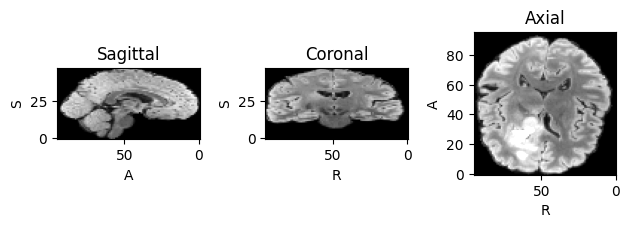

In [38]:
tio.visualization.plot_volume(sub1["fla"]);

In [12]:
import scipy

In [11]:
subject["tumor"].tensor

torch.uint8

In [44]:
scipy.ndimage.center_of_mass()

tensor(1.)

In [16]:
scipy.ndimage.center_of_mass(subject["tumor"].tensor.numpy())

(0.0, 61.56165821234914, 24.423998600664685, 20.905020115445165)

In [19]:
subject.keys()

dict_keys(['tumor', 'category_id', 'category', 'patient_id', 'fla', 't1w', 't1c', 't2w'])

In [22]:
"tumosr" in subject

False

In [26]:
subject.spatial_shape

(96, 96, 48)

In [24]:
subject.shape

(1, 96, 96, 48)

In [30]:
def get_subject(patient_id=0):
    for subject in data_module.subjects:
        if subject.patient_id == patient_id:
            return subject

In [31]:
subject = get_subject(148)

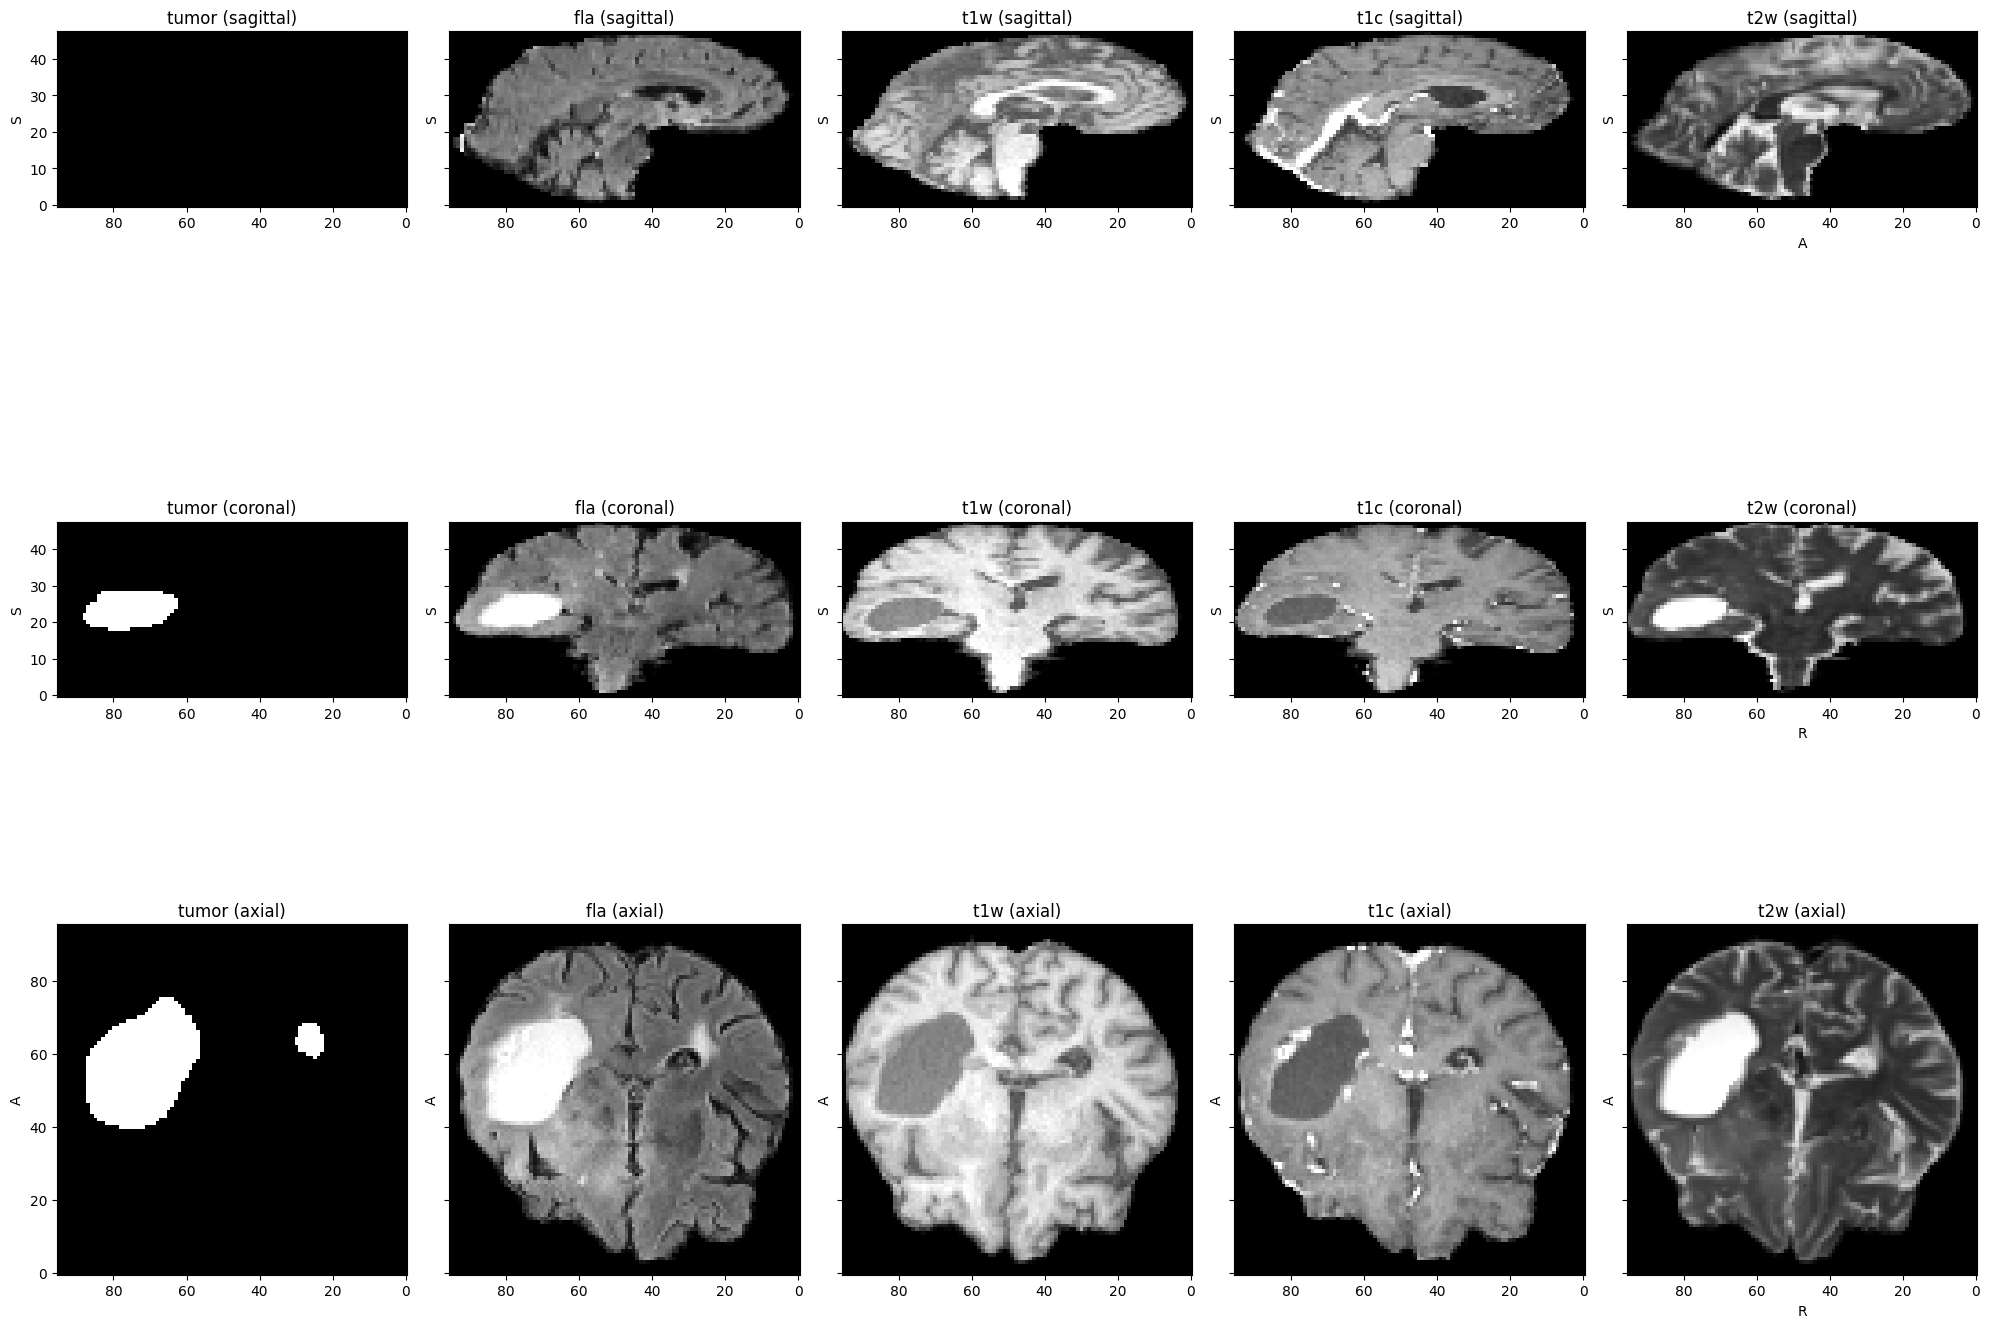

In [34]:
subject.plot(figsize=(20,20))

In [35]:
scipy.sparse.csgraph.connected_components(subject.tumor.tensor.numpy())

ValueError: graph should have two dimensions

In [56]:
# 1, W, H, D
tumor = subject.tumor.tensor.numpy()
tumor = tumor[...,24]
tumor = np.transpose(tumor, (1,2, 0)) # HW1

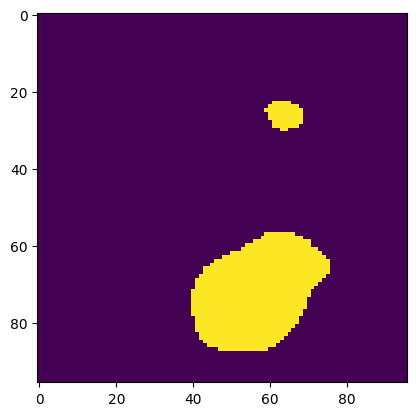

In [57]:
plt.imshow(tumor)

In [37]:
out = scipy.ndimage.label(subject.tumor.tensor.numpy())

In [42]:
out[1]

2

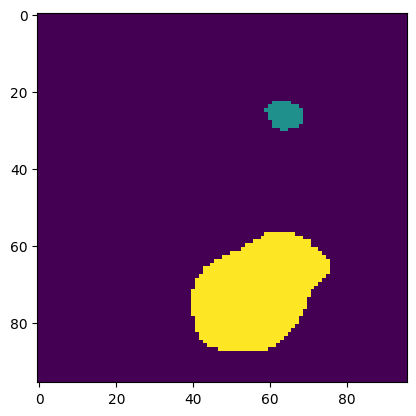

In [59]:
plt.imshow(out[0][..., 24].transpose((1,2,0)))

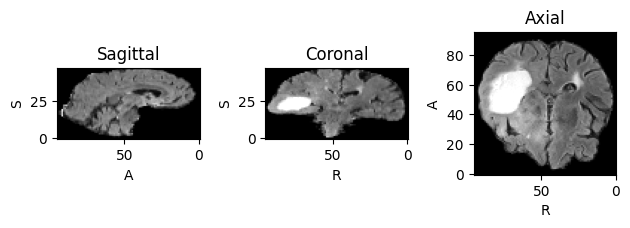

In [60]:
tio.visualization.plot_volume(subject["fla"]);

In [63]:
np.where(out[0], )

2

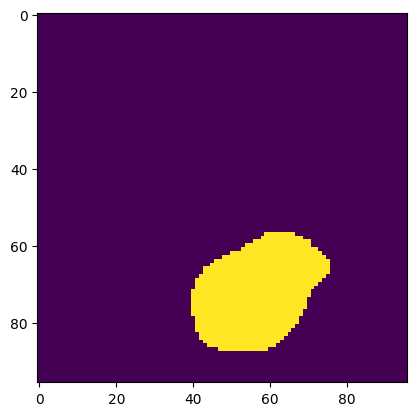

In [67]:
filt = out[0] == 2
plt.imshow(filt[..., 24].transpose((1,2,0)))

In [68]:
out[0].dtype

dtype('int32')

In [69]:
tumor = subject.tumor.tensor.numpy()

In [70]:
tumor.dtype

dtype('uint8')

In [71]:
subject.tumor.count_nonzero()

8696

In [72]:
subject.tumor.count_labels()

{0: 433672, 1: 8696}

In [73]:
out[1]

2

In [75]:
list(range(1, out[1]+1))

[1, 2]

In [77]:
out[0].shape

(1, 96, 96, 48)

In [78]:
labelmap = tio.LabelMap(tensor=out[0])

In [79]:
labelmap.count_labels()

{0: 433672, 1: 646, 2: 8050}

In [92]:
labeled_image, num_labels = scipy.ndimage.label(tumor)
objects = scipy.ndimage.find_objects(labeled_image, max_label=num_labels)

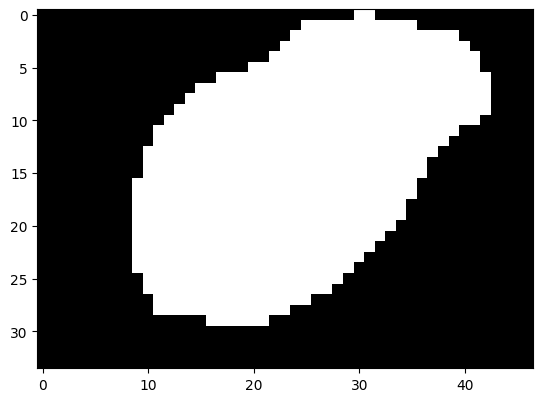

In [122]:
def plot_object_center(tensor, object_slices, depth_index=None):
    tensor_sliced = tensor[object_slices] # C, W, H, D
    if depth_index is None:
        depth_index = tensor_sliced.shape[-1] // 2
    tensor_spatial = tensor_sliced[0, :, :, depth_index]
    plt.imshow(tensor_spatial, cmap="gray")
    return tensor_spatial

spatial = plot_object_center(tumor, objects[1], 9)

In [106]:
sliced = tumor[objects[1]]

In [118]:
objects[1]

(slice(0, 1, None),
 slice(56, 90, None),
 slice(33, 80, None),
 slice(17, 33, None))

In [120]:
fla = subject.fla.tensor.numpy()

array([[ 0.32505456,  0.73179644,  1.0754231 , ...,  0.02350456,
         0.05856851,  0.21284992],
       [ 0.4302464 ,  0.70374525,  0.9001034 , ...,  0.16376038,
         0.32505456,  0.18479875],
       [ 0.40920806,  0.6686813 ,  0.91412896, ...,  0.38816968,
         0.24791387,  0.05856851],
       ...,
       [-2.3187675 , -2.2977293 , -1.5894374 , ..., -2.3187675 ,
        -2.3187675 , -2.3187675 ],
       [-2.3187675 , -2.3187675 , -2.3117547 , ..., -2.3187675 ,
        -2.3187675 , -2.3187675 ],
       [-2.3187675 , -2.3187675 , -2.3187675 , ..., -2.3187675 ,
        -2.3187675 , -2.3187675 ]], dtype=float32)

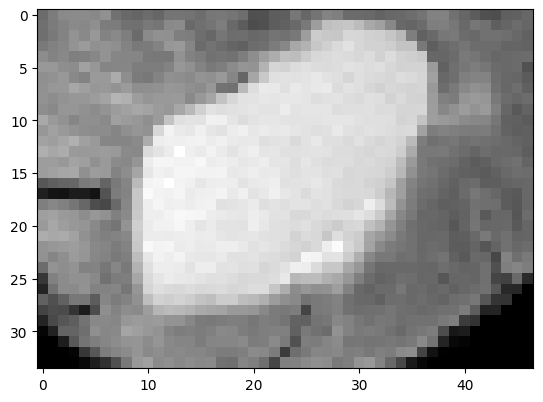

In [123]:
plot_object_center(fla, objects[1])

In [127]:
# subject.fla.tensor[objects[1]]
objects[1]

(slice(0, 1, None),
 slice(56, 90, None),
 slice(33, 80, None),
 slice(17, 33, None))

In [158]:
def slice_to_border_crop(slice_by_dim, spatial_shape):
    # spatial_shape. W, H, D
    border_crop = []
    for slc, spatial_dim in zip(slice_by_dim[1:], spatial_shape):
        border_crop.append(slc.start)
        border_crop.append(spatial_dim - slc.stop)
    return tuple(border_crop)

crop_transform = tio.transforms.Crop(slice_to_border_crop(objects[1], subject.spatial_shape))
crop_transform

Crop(cropping=(56, 6, 33, 16, 17, 15))

In [159]:
subject2 = crop_transform(subject)

In [160]:
subject2.fla

ScalarImage(shape: (1, 34, 47, 16); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 99.9 KiB)

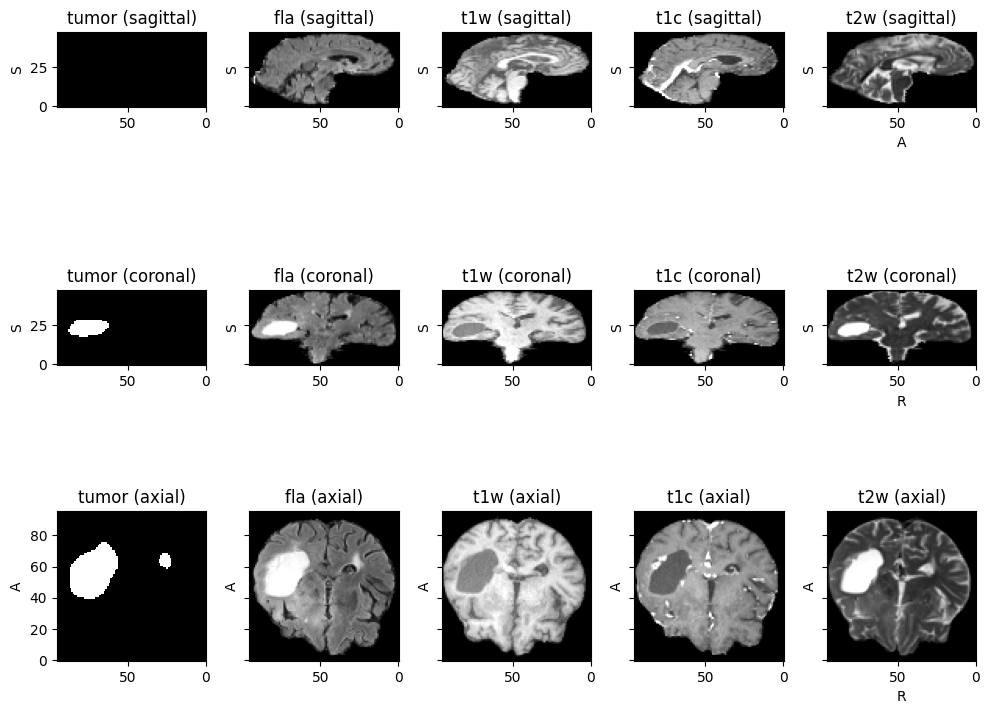

In [163]:
subject.plot(figsize=(10,10))

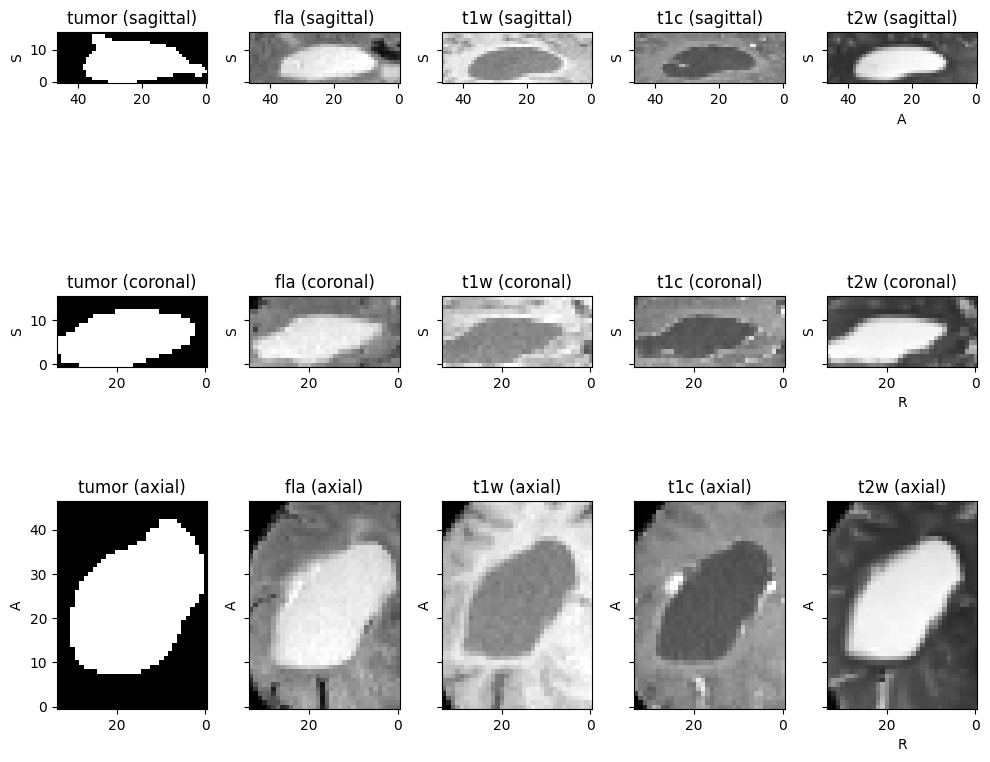

In [164]:
subject2.plot(figsize=(10,10))

In [89]:
lbl = scipy.ndimage.label(tumor)[0]
scipy.ndimage.center_of_mass(lbl, tumor, 1)

(0.0, 70.6415860504001, 57.525558342290694, 23.617042875910666)

In [90]:
scipy.ndimage.center_of_mass(lbl, tumor, 2)

invalid value encountered in double_scalars


(nan, nan, nan, nan)

In [88]:
scipy.ndimage.center_of_mass?

In [144]:
objects[1][1].indices

slice(56, 90, None)

In [149]:
objects[1][1].indices(1)

(1, 1, 1)

In [150]:
def SliceToRange(slc: slice) -> range:
    """Function for Converting a Slice to a Range"""
    DefaultTo = lambda value, default: value if value is not None else default
    return range(DefaultTo(slc.start, 0), slc.stop, DefaultTo(slc.step, 1))

In [151]:
SliceToRange(objects[1][1])

range(56, 90)

In [152]:
objects[1][1].start

56

In [156]:
objects[1][1].stop

90

In [167]:
tumor.shape

(1, 96, 96, 48)

AttributeError: AxesImage.set() got an unexpected keyword argument 'cmap_dict'

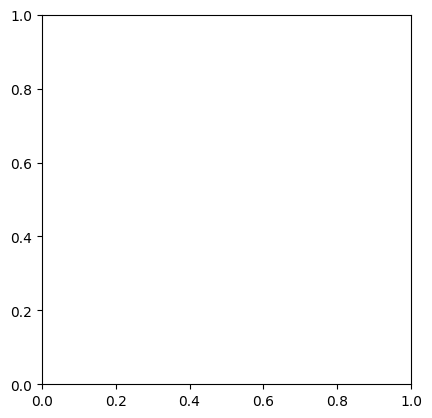

In [507]:
plt.imshow(tumor[..., 24].transpose((1,2,0)), cmap_dict="gray")

In [187]:
tumor_blur = scipy.ndimage.gaussian_filter(tumor, 0)

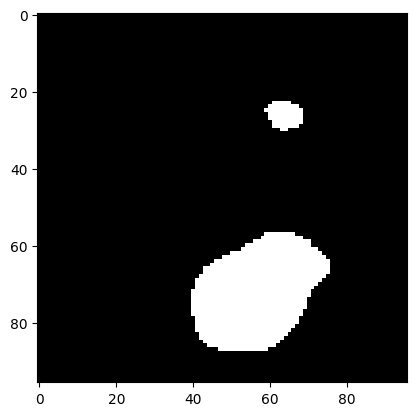

In [188]:
plt.imshow(tumor_blur[..., 24].transpose((1,2,0)), cmap="gray")

In [178]:
tumor_blur.shape

(1, 96, 96, 48)

In [191]:
T = tumor == 1

In [192]:
T.sum()

8696

In [193]:
tumor.sum()

8696

In [200]:
A = [(1, 200), (2, 100)]
B = sorted(A, key= lambda x: x[1], reverse=True)
B

[(1, 200), (2, 100)]

In [205]:
list(zip(*B))

[(1, 2), (200, 100)]

In [207]:
labeled_image.shape

(1, 96, 96, 48)

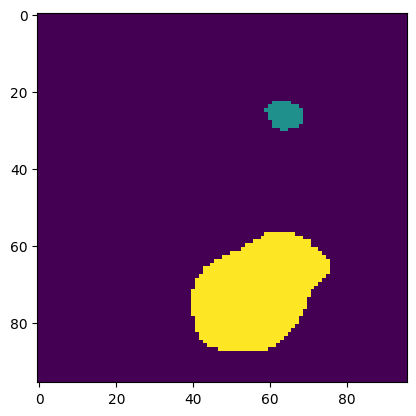

In [209]:
plt.imshow(labeled_image[..., 24].transpose((1,2,0)))

In [211]:
import copy

In [212]:
copy.deepcopy(labeled_image)

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
    

In [214]:
labeled_image.max()

2

In [215]:
scipy.ndimage.center_of_mass(labeled_image == 1)

(0.0, 27.356037151702786, 63.360681114551085, 26.36687306501548)

In [216]:
scipy.ndimage.center_of_mass(labeled_image == 2)

(0.0, 72.37838509316771, 57.29142857142857, 23.50670807453416)

In [276]:
from mgmt.utils.segmentation import make_label_mask, center_of_mass_per_label, find_objects_fixed_crop

In [283]:
label_mask, num_labels = make_label_mask(tumor[0])

In [287]:
tumor.shape[0] == 1

True

In [284]:
label_mask.shape

(96, 96, 48)

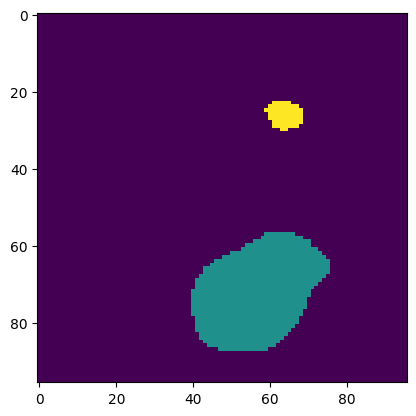

In [285]:
plt.imshow(label_mask[..., 24])

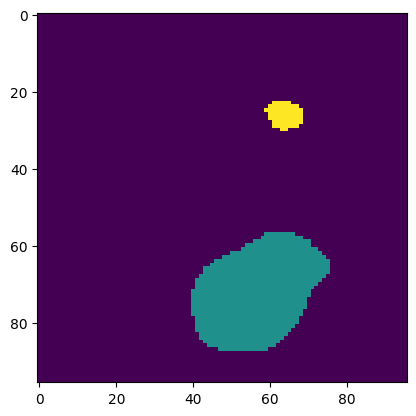

In [233]:
plt.imshow(label_mask[..., 24].transpose((1,2,0)))

In [236]:
com = center_of_mass_per_label(label_mask)

In [237]:
com

[(0.0, 72.37838509316771, 57.29142857142857, 23.50670807453416),
 (0.0, 27.356037151702786, 63.360681114551085, 26.36687306501548)]

In [238]:
objects = scipy.ndimage.find_objects(label_mask)
objects

[(slice(0, 1, None),
  slice(56, 90, None),
  slice(33, 80, None),
  slice(17, 33, None)),
 (slice(0, 1, None),
  slice(22, 34, None),
  slice(56, 70, None),
  slice(19, 32, None))]

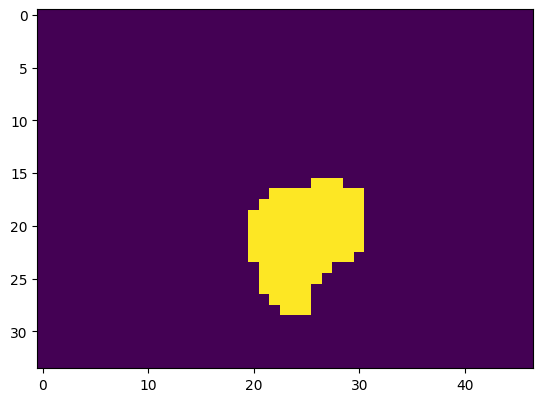

In [263]:
sliced = label_mask[objects[0]]

plt.imshow(sliced[..., 0].transpose((1,2,0)))

In [264]:
sliced.shape

(1, 34, 47, 16)

In [277]:
objects_fixed = find_objects_fixed_crop(label_mask, (1, 40, 40, 9))
objects_fixed

[(slice(0, 1, None),
  slice(52, 92, None),
  slice(37, 77, None),
  slice(19, 28, None)),
 (slice(0, 1, None),
  slice(7, 47, None),
  slice(43, 83, None),
  slice(21, 30, None))]

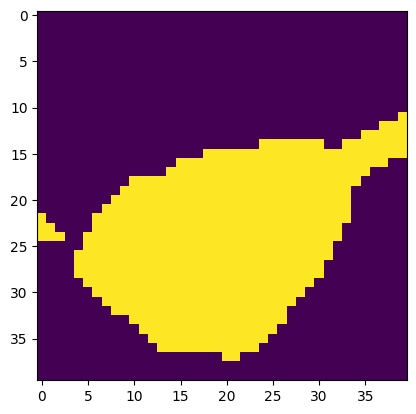

In [278]:
sliced_fixed = label_mask[objects_fixed[0]]

plt.imshow(sliced_fixed[..., 0].transpose((1,2,0)))

In [280]:
sliced_fixed.shape

(1, 40, 40, 9)

In [251]:
A[slice(0, 9)]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [252]:
slice(0, 9)

slice(0, 9, None)

In [254]:
label_mask.shape

(1, 96, 96, 48)

In [256]:
A = slice(0, 1)

In [257]:
type(A)

slice

In [348]:
from mgmt.data.subject_transforms import CropLargestTumor

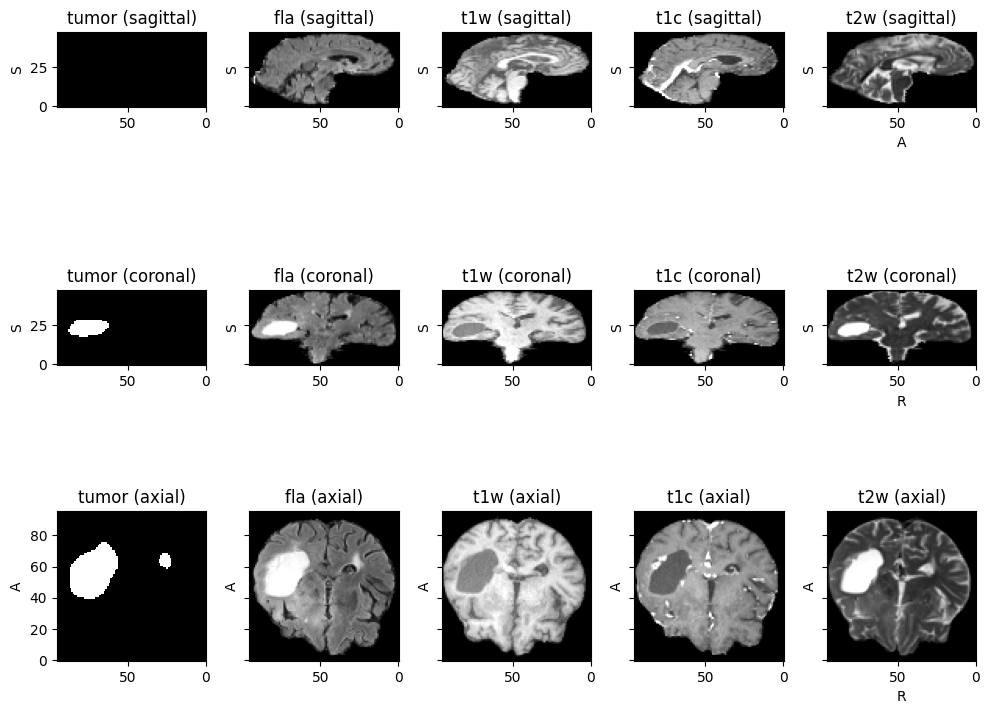

In [349]:
subject.plot(figsize=(10,10))

In [413]:
crop_transform = CropLargestTumor((40, 40, 16))

In [414]:
subject2 = crop_transform(subject)

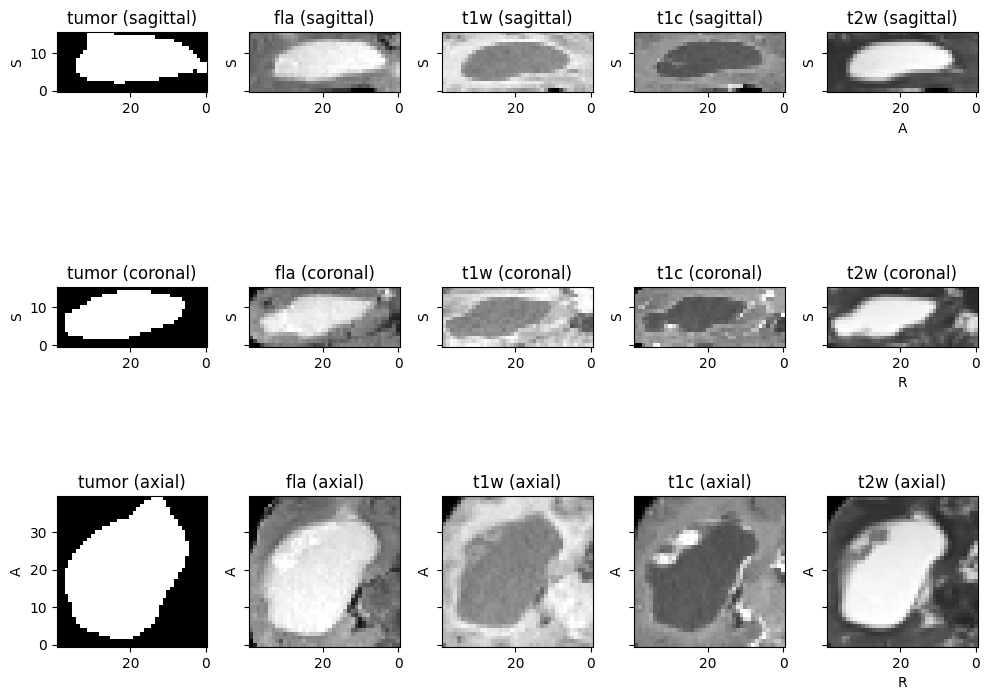

In [415]:
subject2.plot(figsize=(10,10))

In [416]:
shape_mult_trans = tio.EnsureShapeMultiple(8)

In [417]:
subject3 = shape_mult_trans(subject2)

In [409]:
subject3.spatial_shape

(40, 40, 8)

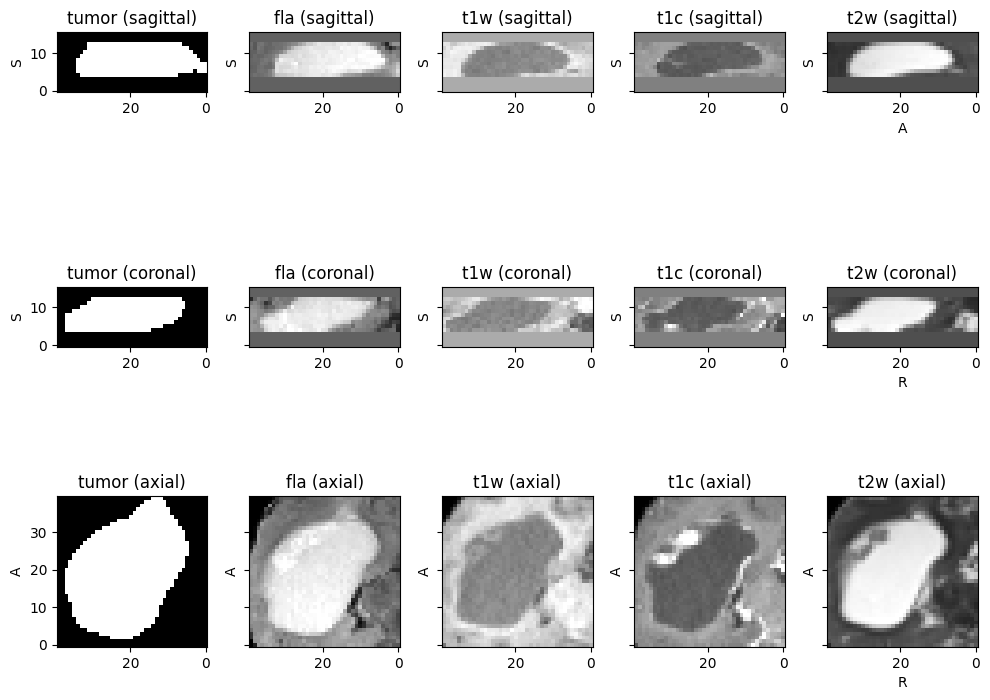

In [357]:
subject3.plot(figsize=(10,10))

In [359]:
subject4 = tio.OneHot()(subject3)

In [361]:
subject4.tumor

LabelMap(shape: (2, 40, 40, 16); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.ByteTensor; memory: 50.0 KiB)

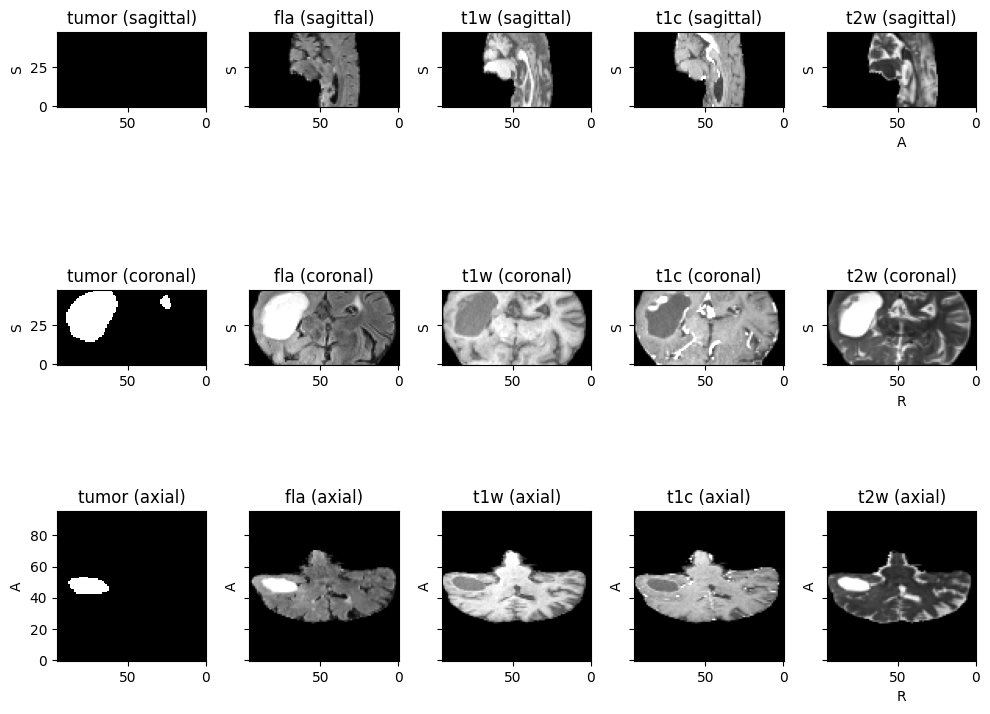

In [401]:
rot = tio.RandomAffine(scales = 0, degrees=(90, 90, 0, 0, 0,0), translation=0, p=1)(subject)
rot.plot(figsize=(10,10), indices=(48, 48, 24))

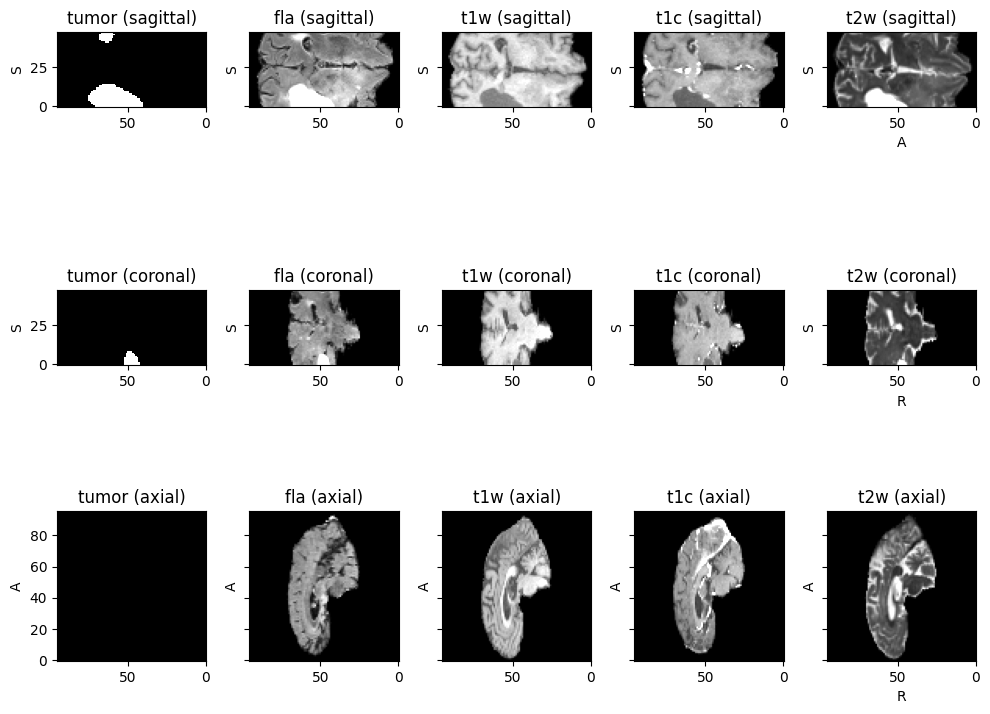

In [402]:
rot = tio.RandomAffine(scales = 0, degrees=(0, 0, 90, 90, 0,0), translation=0, p=1)(subject)
rot.plot(figsize=(10,10), indices=(48, 48, 24))

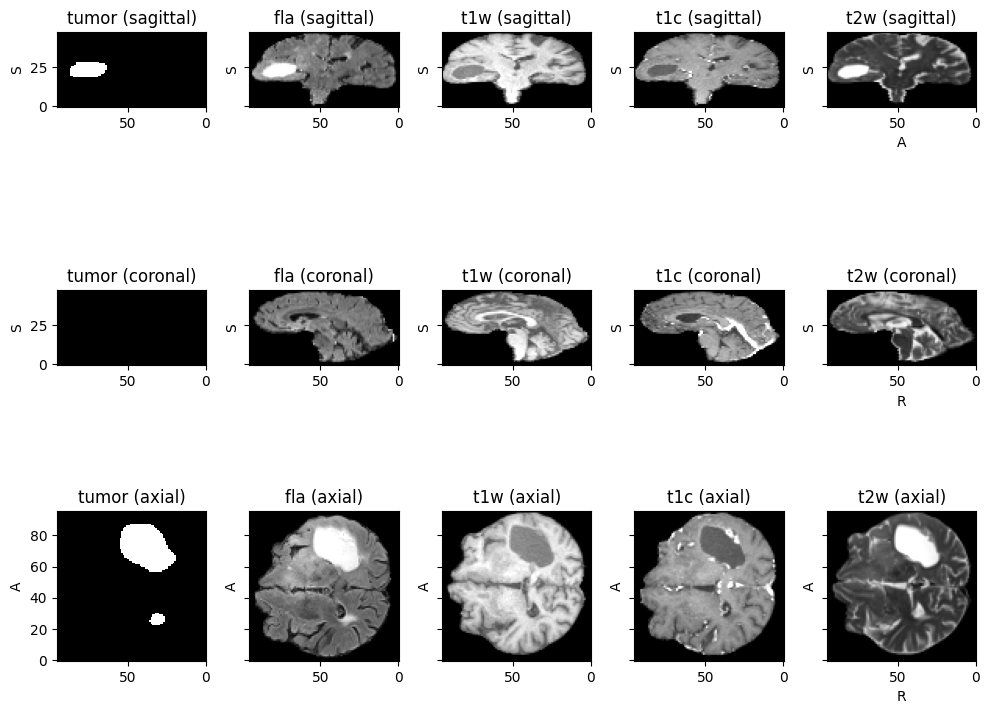

In [403]:
rot = tio.RandomAffine(scales = 0, degrees=(0, 0, 0, 0, 90, 90), translation=0, p=1)(subject)
rot.plot(figsize=(10,10), indices=(48, 48, 24))

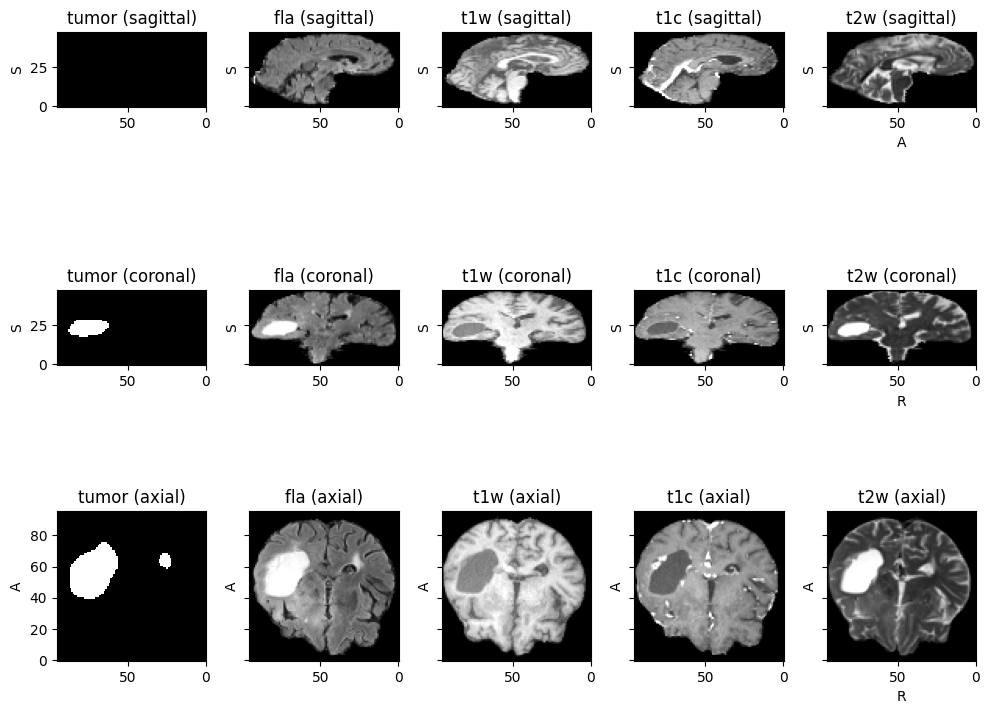

In [399]:
subject.plot(figsize=(10,10), indices=(48, 48, 24))

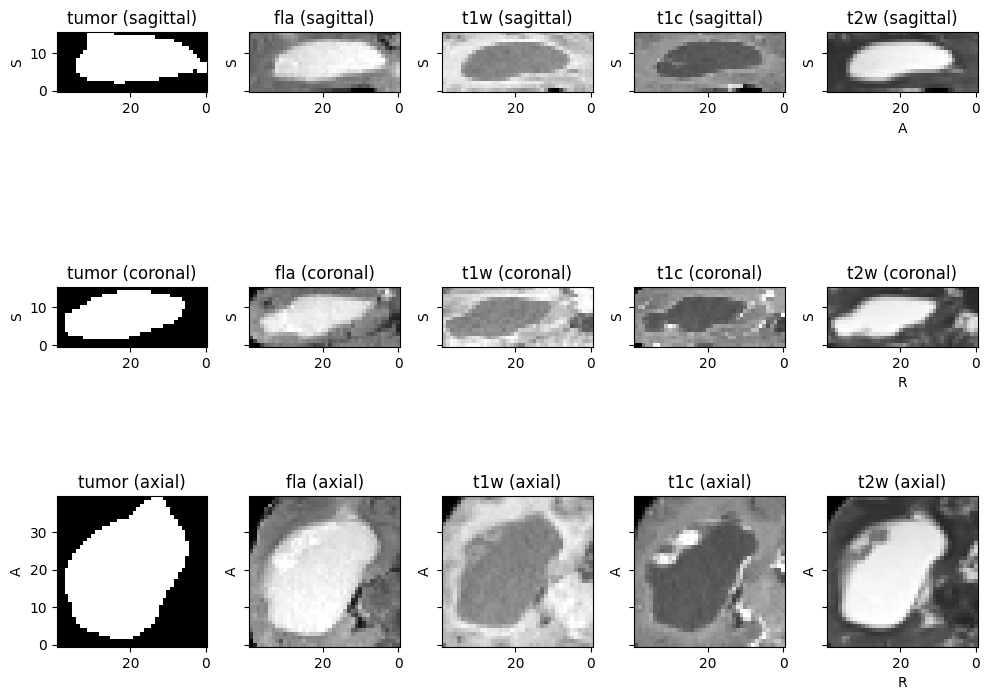

In [420]:
subject3.plot(figsize=(10,10), indices=(20, 20, 8))

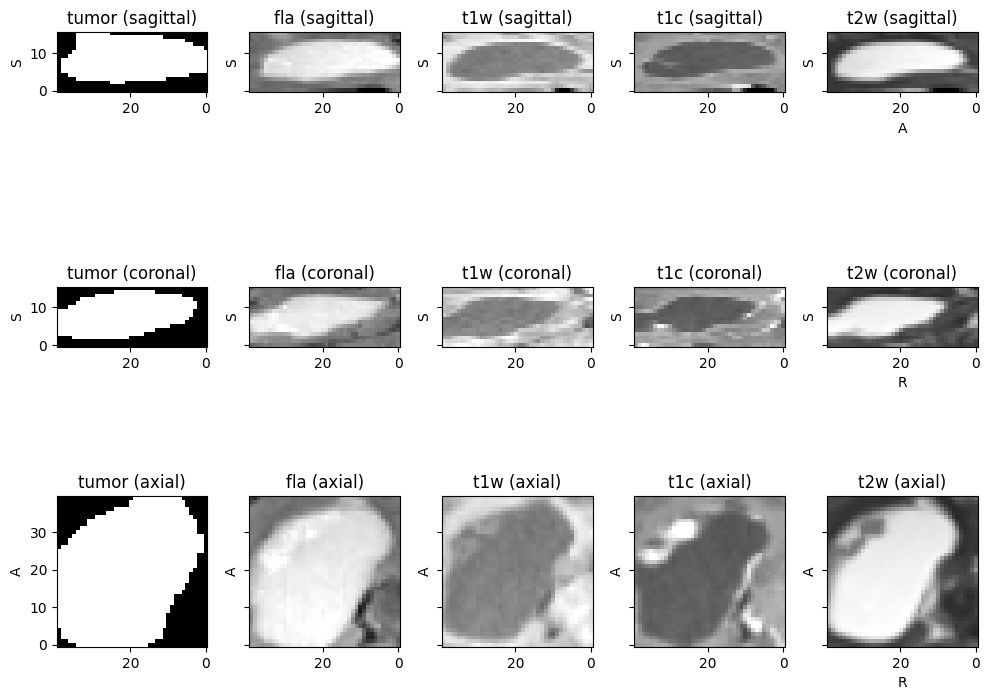

In [447]:
affine = tio.RandomAffine(scales = (1.25, 1.25, 1.25, 1.25, 1, 1), degrees=(0, 0, 0, 0, 0, 0), translation=0, p=1)
rot = affine(subject3)
rot.plot(figsize=(10,10), indices=(20, 20, 8))

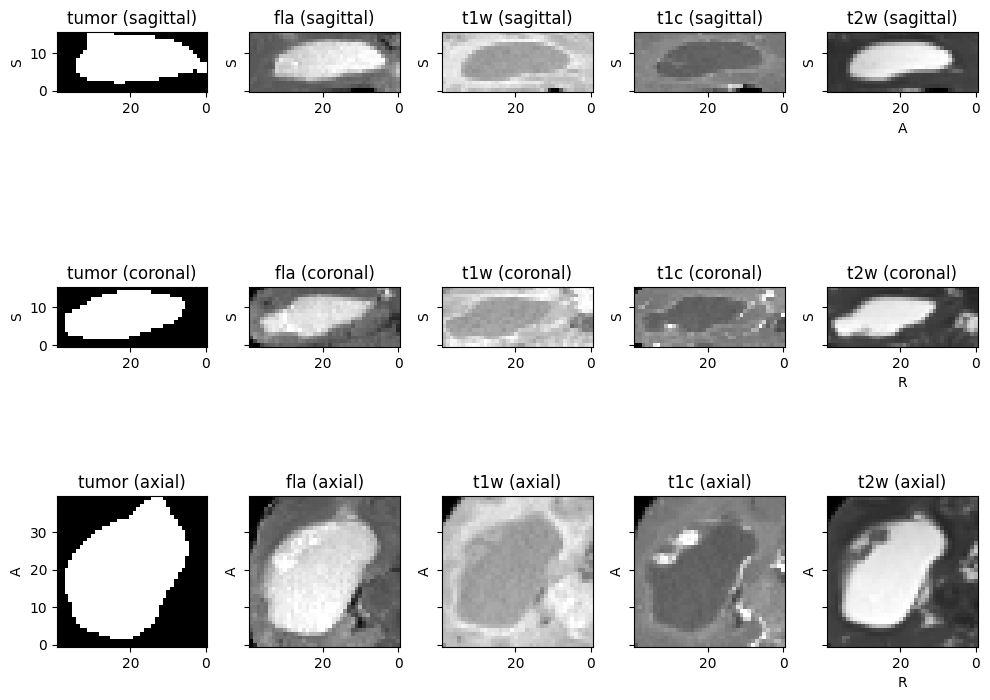

In [448]:
trans = tio.RandomGamma(log_gamma=(0.3, 0.3), p=1)(subject3)
trans.plot(figsize=(10,10), indices=(20, 20, 8))

In [463]:
subject3.fla.numpy().min()

-2.3187675

In [464]:
subject3.fla.numpy().max()

4.0

In [465]:
subject.fla.numpy().min()

-2.3187675

In [469]:
subject2.fla.numpy().max()

4.0

In [472]:
subject2.fla.numpy()

array([[[[-2.3187675 , -2.3187675 , -2.3187675 , ...,  0.07960688,
          -0.03259777, -0.09571289],
         [-2.3187675 , -2.3187675 , -2.3187675 , ...,  0.32505456,
           0.10064526, -0.06766172],
         [-2.3187675 , -2.3187675 , -2.3187675 , ...,  0.19882433,
          -0.09571289,  0.35310572],
         ...,
         [ 0.33206734,  0.9982825 ,  0.5354383 , ...,  0.20583712,
           0.30401617, -0.00454661],
         [-0.19389196,  0.69673246,  0.42323363, ...,  0.26895222,
           0.46531036,  0.32505456],
         [-1.2317849 , -0.13077684,  0.11467084, ...,  0.05155572,
           0.07259409,  0.01649177]],

        [[-2.3187675 , -2.3187675 , -2.3187675 , ..., -0.2429815 ,
          -0.0816873 ,  0.12168363],
         [-2.3187675 , -2.3187675 , -2.3187675 , ...,  0.00947898,
           0.6897197 ,  0.35310572],
         [-2.3187675 , -2.3187675 , -2.3187675 , ...,  0.10064526,
           0.2899906 ,  0.24791387],
         ...,
         [ 0.10765804, -0.17285359

In [473]:
from mgmt.data.subject_transforms import CropLargestTumor

In [494]:
subject1 = CropLargestTumor((40, 40, 9))(subject)
subject2 = tio.RescaleIntensity(out_min_max=(-1, 1), percentiles=(0, 100))(subject1)

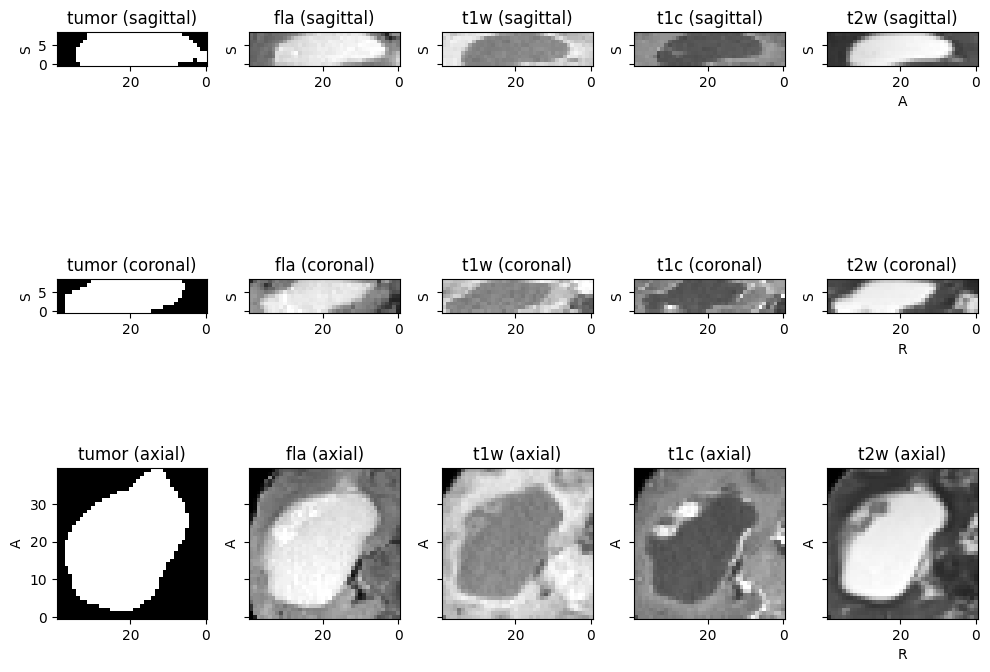

In [497]:
subject1.plot(figsize=(10,10), indices=(20, 20, 4))

In [499]:
subject2.fla.numpy().min(), subject2.fla.numpy().max()

(-1.0, 1.0)

In [502]:
subject_trans = tio.RandomMotion(degrees=10, translation=5)(subject2)

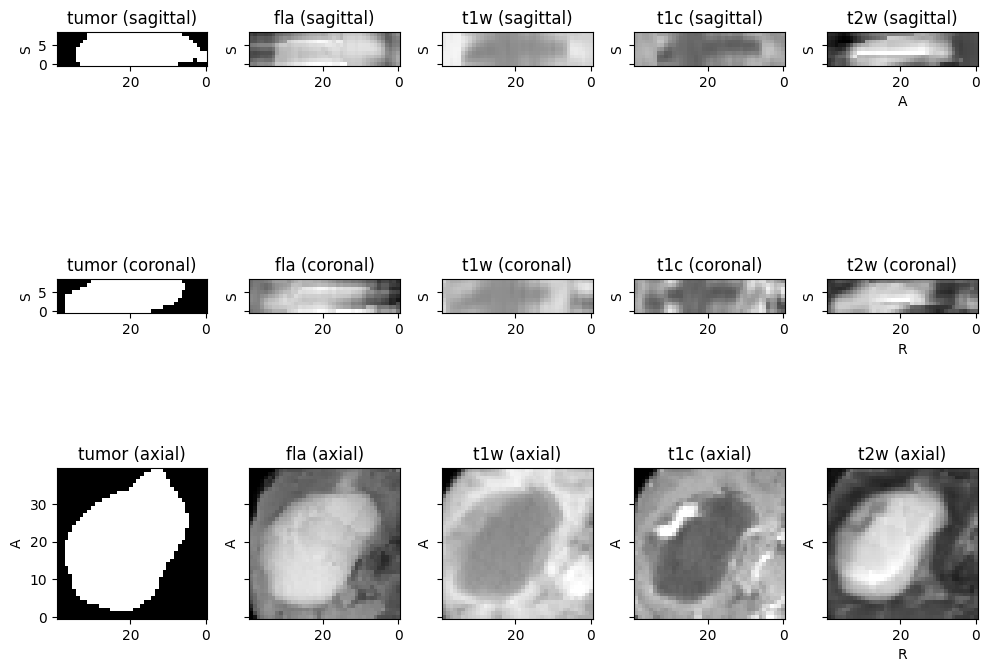

In [503]:
subject_trans.plot(figsize=(10,10), indices=(20, 20, 4))

In [505]:
tio.DATA

'data'

In [506]:
subject.keys()

dict_keys(['tumor', 'category_id', 'category', 'patient_id', 'fla', 't1w', 't1c', 't2w'])